In [34]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from PIL import Image
import numpy as np
import cv2
import os

In [35]:
data_path = Path(os.getcwd()) / 'isr_wall'

kps_fpaths = sorted((data_path / 'input').glob('*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

imgs_fpaths = sorted((data_path / 'input').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

ref_kps_fpath = data_path / 'reference' / 'kp_ref.mat'
ref_img_fpath = data_path / 'reference' / 'img_ref.jpg'

In [36]:
def resize_keypoint_and_image(keypoint, image, scale_factor):
    """
    Resize a single keypoint array and image by a given scale factor.

    Args:
        keypoint (np.ndarray): Keypoint array.
        image (np.ndarray): Image array.
        scale_factor (float): Scale factor to resize the keypoint and image.

    Returns:
        resized_keypoint (np.ndarray): Resized keypoint array.
        resized_image (np.ndarray): Resized image array.
    """
    resized_keypoint = keypoint * scale_factor
    resized_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
    
    return resized_keypoint, resized_image

In [37]:
keypoints = [spio.loadmat(fpath)['kp'] for fpath in kps_fpaths]
descriptors = [spio.loadmat(fpath)['desc'] for fpath in kps_fpaths]

ref_keypoints = spio.loadmat(ref_kps_fpath)['kp']
ref_descriptors = spio.loadmat(ref_kps_fpath)['desc']

images = [np.array(Image.open(fpath)) for fpath in imgs_fpaths]
ref_img = np.array(Image.open(ref_img_fpath))

In [38]:
scale_factor = 0.5 # Resizing images for lower memory consumption in canvas

for i in range(len(keypoints)):
    keypoints[i], images[i] = resize_keypoint_and_image(keypoints[i], images[i], scale_factor)

ref_keypoints, ref_img = resize_keypoint_and_image(ref_keypoints, ref_img, scale_factor)


In [39]:
class ImageNode:
    def __init__(self, image, keypoints, descriptors, idx):
        self.image = image
        self.keypoints = keypoints
        self.descriptors = descriptors
        self.idx = idx
        self.homography = None
        self.footprint = []

    def __str__(self):
        return f"ImageNode(idx={self.idx}, keypoints_shape={self.keypoints.shape}, descriptors_shape={self.descriptors.shape}, footprint={self.footprint})"


image_nodes = [ImageNode(image, kp, desc, idx) for idx, (image, kp, desc) in enumerate(zip(images, keypoints, descriptors))]
image_node_ref = ImageNode(ref_img, ref_keypoints, ref_descriptors, idx=-1)

In [40]:
def find_matches(src_node, dst_node):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(src_node.descriptors, dst_node.descriptors)
    src_pts = np.float32([src_node.keypoints[m.queryIdx] for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([dst_node.keypoints[m.trainIdx] for m in matches]).reshape(-1, 1, 2)
    return src_pts, dst_pts

In [41]:
def compute_min_inliers_threshold(image_nodes):
    inliers_per_pair = []

    for i in range(len(image_nodes) - 1):
        src_pts, dst_pts = find_matches(image_nodes[i], image_nodes[i+1])
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        inliers = np.sum(mask)
        inliers_per_pair.append(inliers)

    min_inliers = min(inliers_per_pair)
    return min_inliers

min_inliers_threshold = compute_min_inliers_threshold(image_nodes)
print('The minimum number of inliers is:', min_inliers_threshold)

The minimum number of inliers is: 545


In [42]:
def find_valid_homography(src_node, dst_node, min_inliers_threshold):
    src_pts, dst_pts = find_matches(src_node, dst_node)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    num_inliers = np.sum(mask)
    is_H_valid = 1 if num_inliers >= min_inliers_threshold else 0
    return H, is_H_valid, num_inliers

In [43]:
def find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold):
    valid_homographies = {1: []}

    for i in range(len(image_nodes)):
        H, is_H_valid, num_inliers = find_valid_homography(image_nodes[i], image_node_ref, min_inliers_threshold)
        
        if is_H_valid:
            image_nodes[i].homography = H
            image_nodes[i].footprint.append('ref')
            valid_homographies[1].append(i)
    return valid_homographies

valid_homographies = find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold)

In [44]:
from itertools import chain

def find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold):
    level = 1
    while level in valid_homographies:
        best_idxs = valid_homographies[level]
        for node in image_nodes:
            if node.idx in list(chain.from_iterable(valid_homographies.values())):
                continue

            nearest_idx = min(best_idxs, key=lambda x: abs(x - node.idx))
            H, is_H_valid, num_inliers = find_valid_homography(node, image_nodes[nearest_idx], min_inliers_threshold)

            if is_H_valid:
                node.homography = np.dot(image_nodes[nearest_idx].homography, H) # Double check if this math is correct
                valid_homographies.setdefault(level + 1, []).append(node.idx)
                node.footprint.append(nearest_idx)
                node.footprint.extend(image_nodes[nearest_idx].footprint)
        level += 1

find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold)

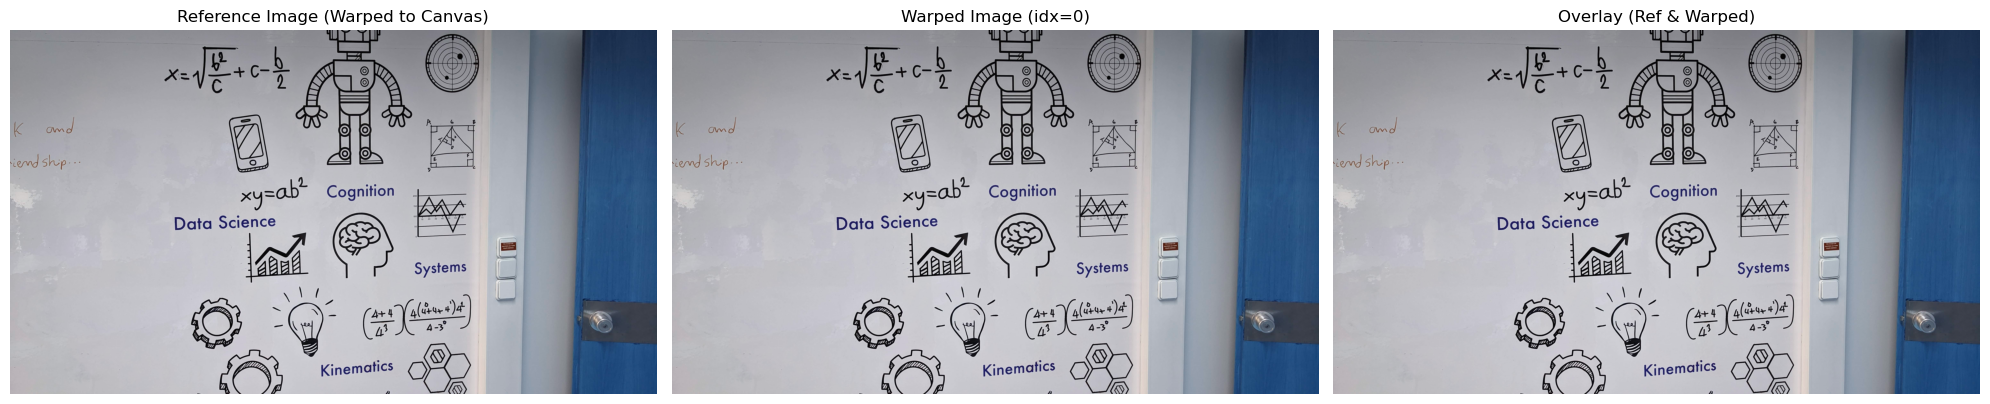

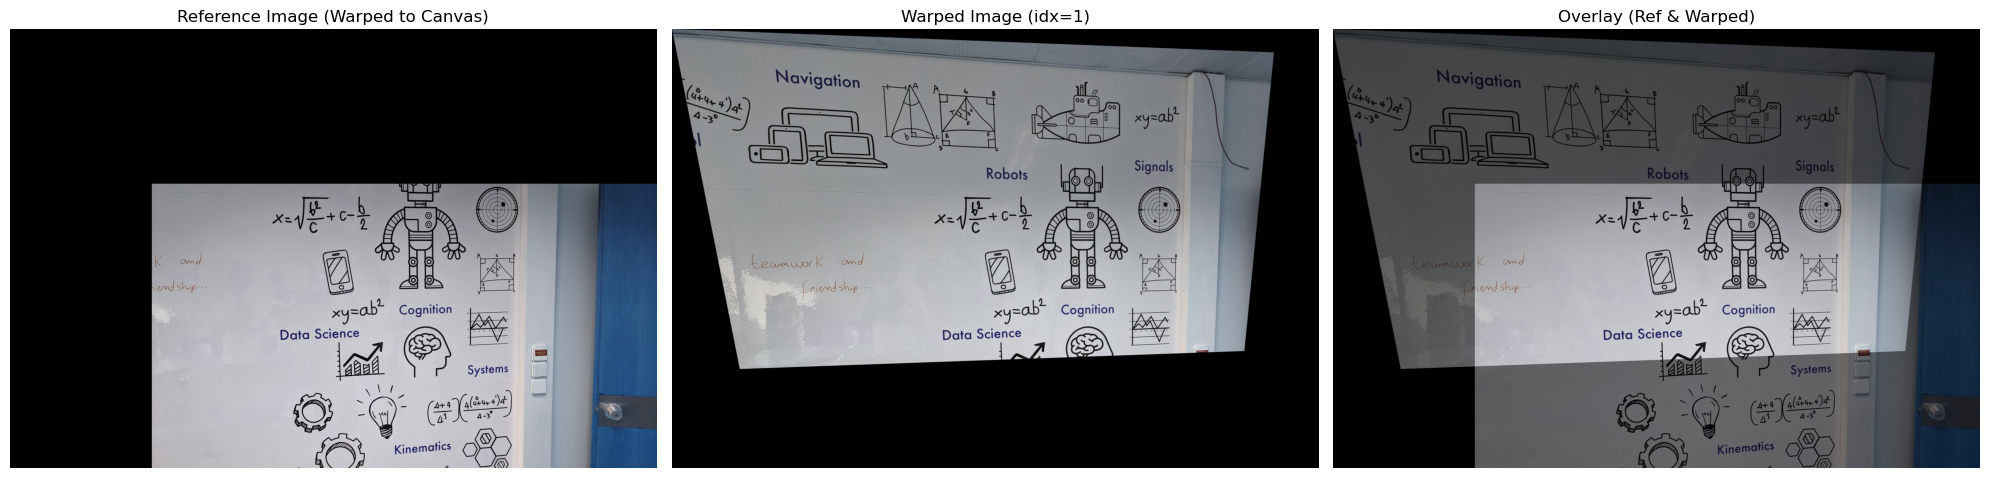

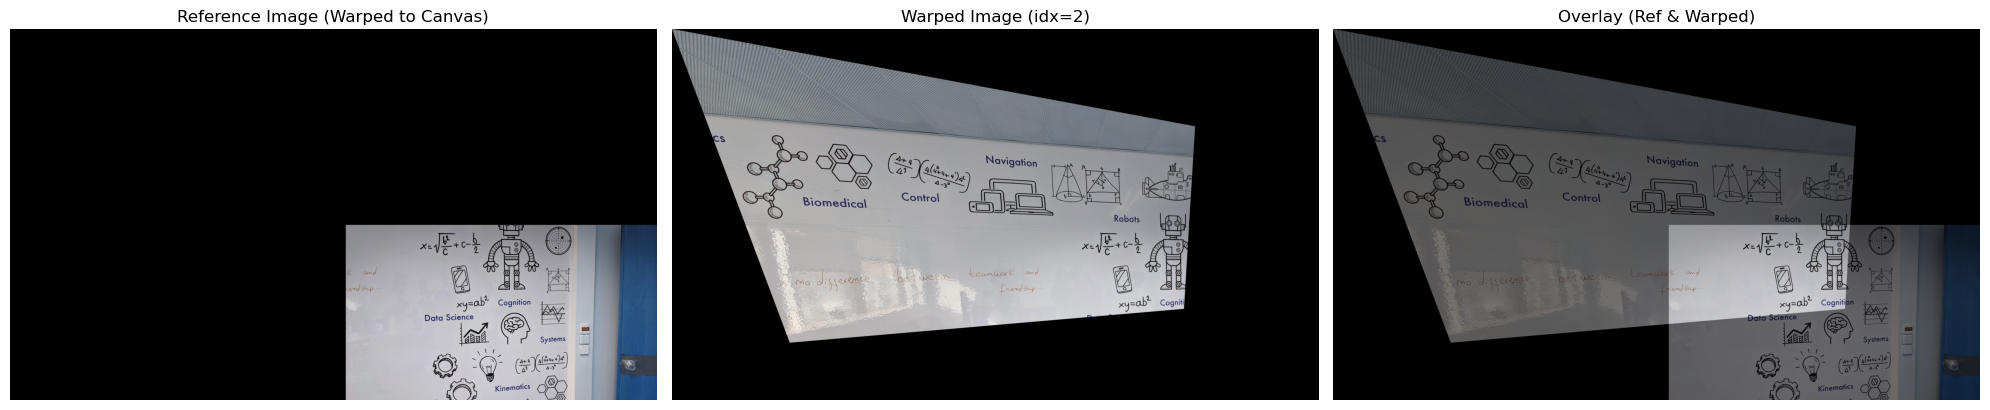

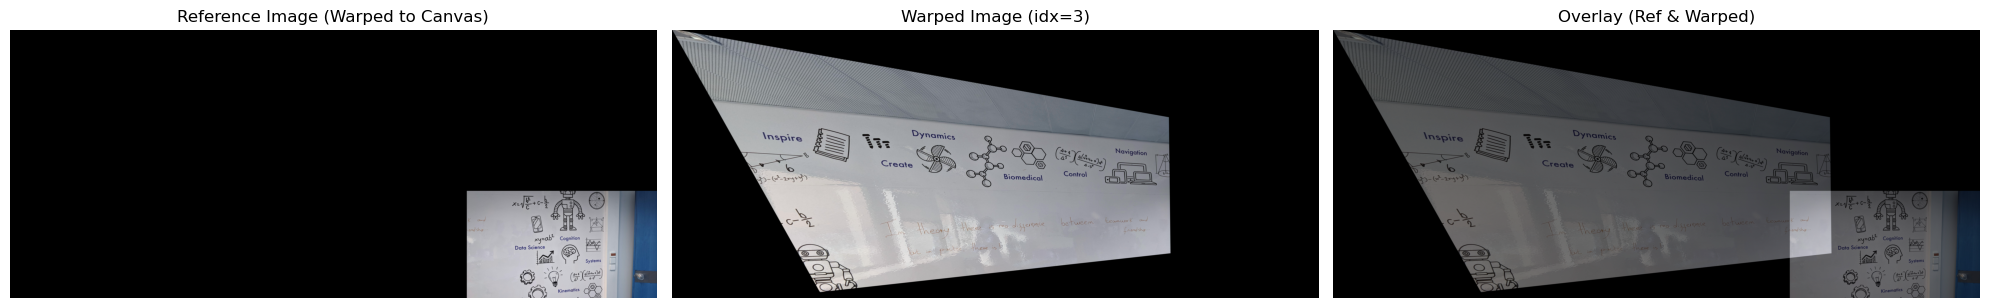

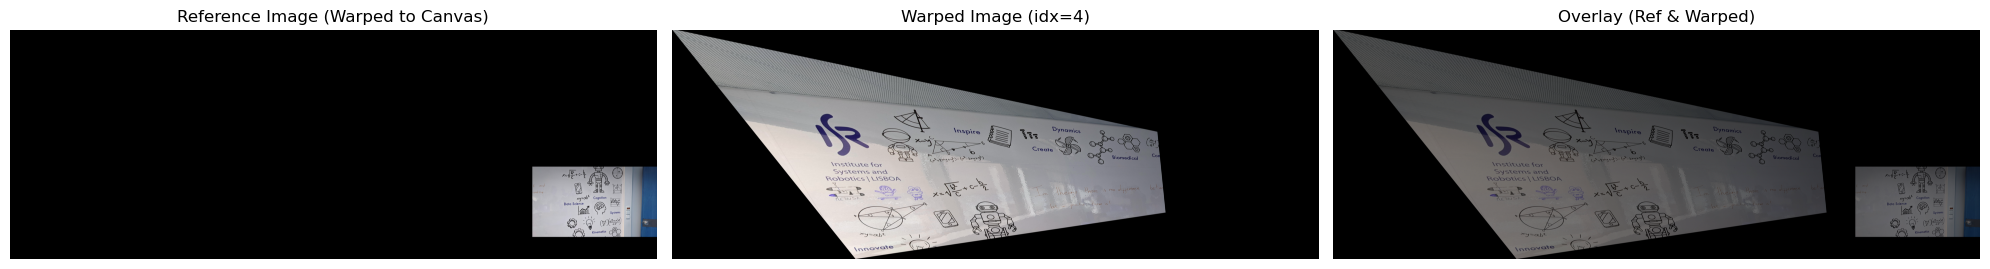

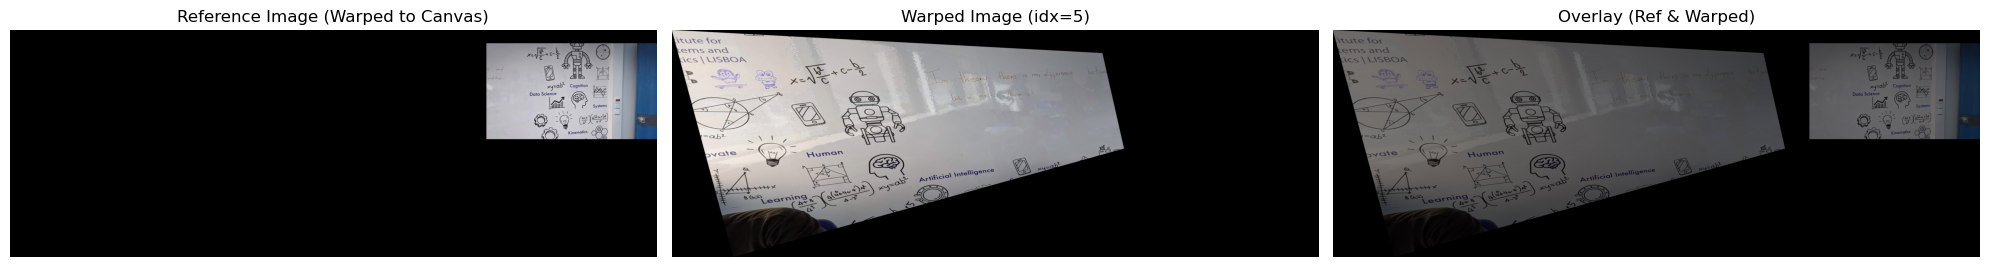

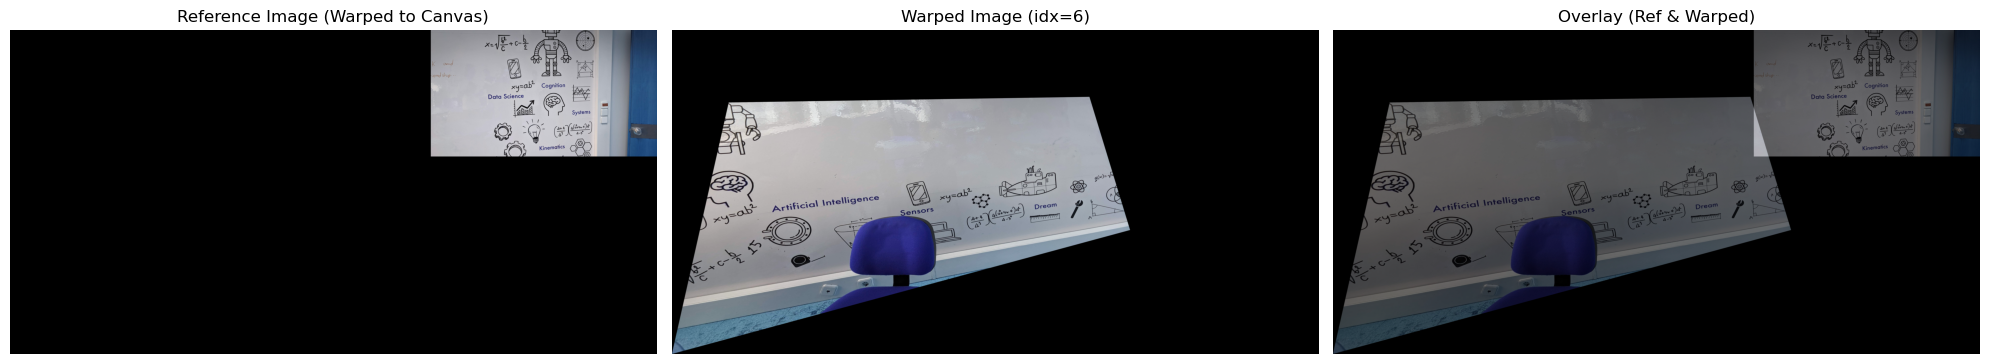

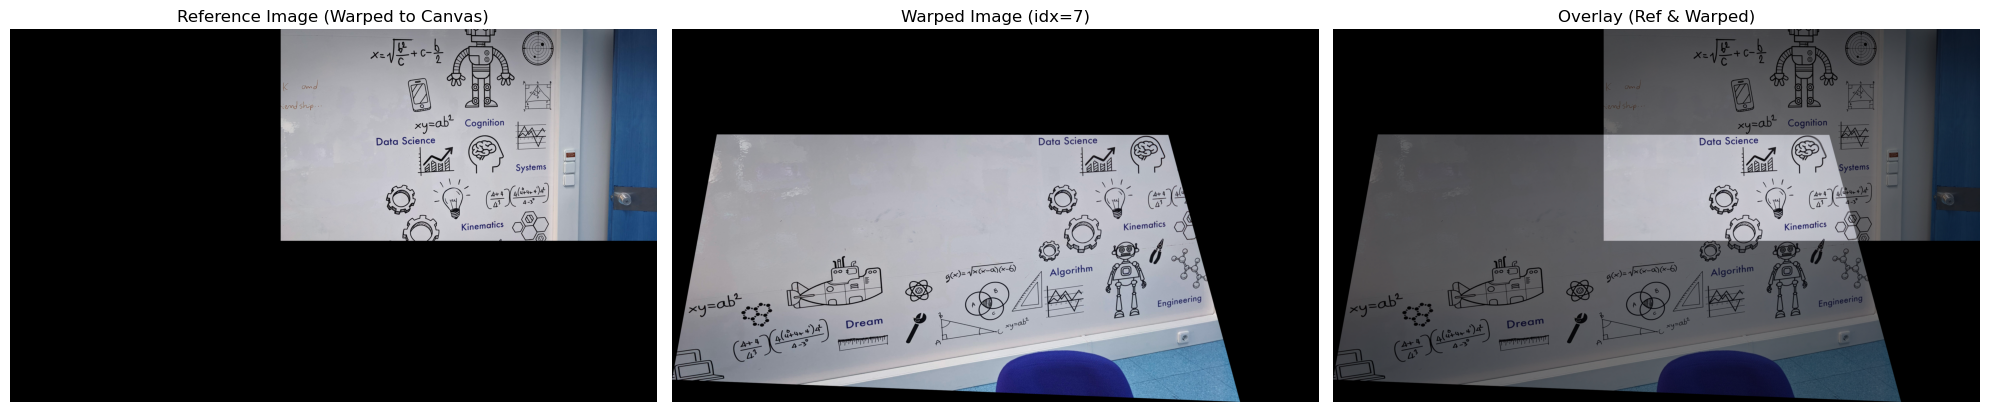

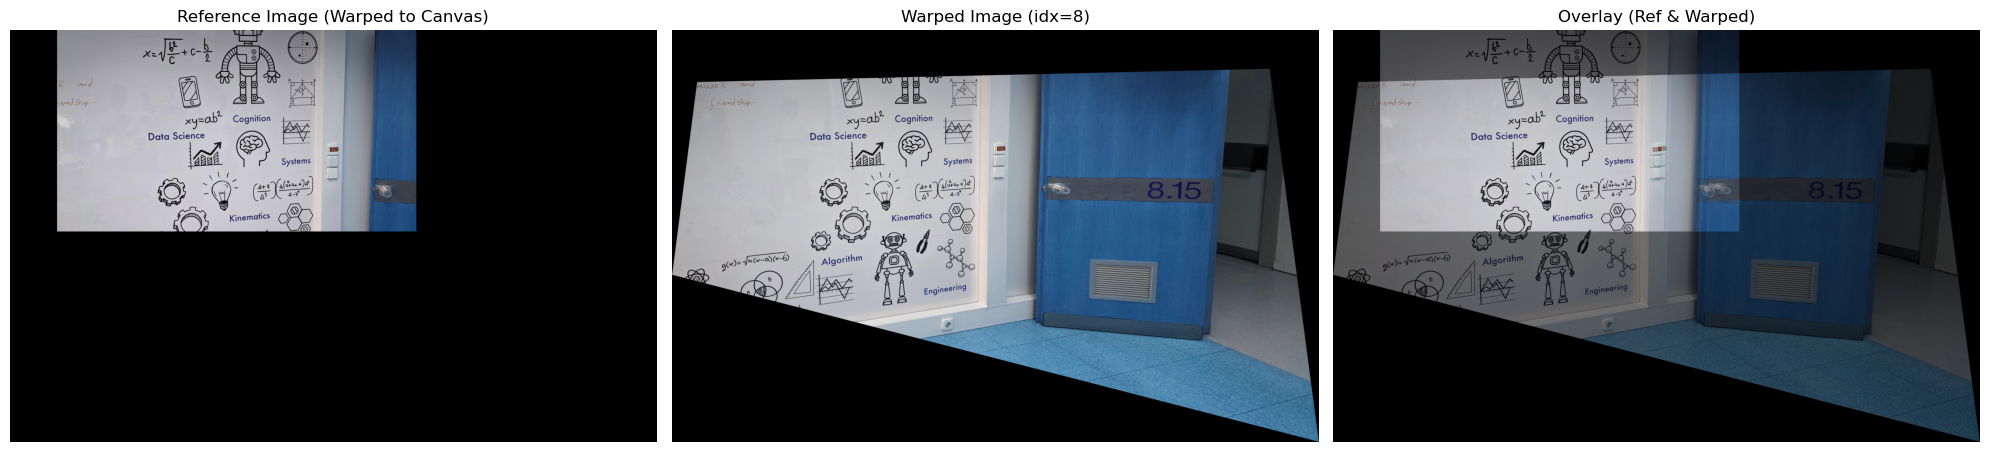

In [45]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_homography_alignment(ref_img, image_nodes):
    """
    For each image node, warp the image to the reference frame using the computed homography
    and plot the warped image alongside the reference without cropping any content.
    """
    for node in image_nodes:
        if node.homography is not None:
            # Ensure homography is of type float32
            H = node.homography.astype(np.float32)

            # Get the shapes of the reference and current images
            h_ref, w_ref = ref_img.shape[:2]
            h_warp, w_warp = node.image.shape[:2]

            # Define the corners of the reference and current images
            corners_ref = np.array([
                [0, 0],
                [w_ref, 0],
                [w_ref, h_ref],
                [0, h_ref]
            ], dtype=np.float32).reshape(-1, 1, 2)

            corners_warp = np.array([
                [0, 0],
                [w_warp, 0],
                [w_warp, h_warp],
                [0, h_warp]
            ], dtype=np.float32).reshape(-1, 1, 2)

            # Warp the corners of the current image to the reference frame
            warped_corners = cv2.perspectiveTransform(corners_warp, H)

            # Combine corners to find the overall bounds
            all_corners = np.concatenate((corners_ref, warped_corners), axis=0)

            [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

            # Compute the translation needed to shift the images
            translation = [-xmin, -ymin]

            # Define the translation matrix with float32 type
            translation_matrix = np.array([
                [1, 0, translation[0]],
                [0, 1, translation[1]],
                [0, 0, 1]
            ], dtype=np.float32)

            # Warp the reference image using the translation matrix
            ref_warped = cv2.warpPerspective(ref_img, translation_matrix, (xmax - xmin, ymax - ymin))

            # Warp the current image using the combined translation and homography matrices
            combined_homography = translation_matrix @ H  # Matrix multiplication
            warped_img = cv2.warpPerspective(node.image, combined_homography, (xmax - xmin, ymax - ymin))

            # Create an overlay by blending the two images
            # Convert images to float for blending
            ref_float = ref_warped.astype(np.float32)
            warped_float = warped_img.astype(np.float32)

            # Normalize images to range [0,1] if they are not already
            if ref_float.max() > 1.0:
                ref_float /= 255.0
            if warped_float.max() > 1.0:
                warped_float /= 255.0

            # Handle different number of channels
            if ref_float.ndim == 2:
                ref_float = cv2.cvtColor(ref_float, cv2.COLOR_GRAY2RGB)
            if warped_float.ndim == 2:
                warped_float = cv2.cvtColor(warped_float, cv2.COLOR_GRAY2RGB)

            # Blend with 50-50 transparency
            overlay = cv2.addWeighted(ref_float, 0.5, warped_float, 0.5, 0)
            overlay = (overlay * 255).astype(np.uint8)

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(20, 10))

            # Show the reference warped image
            axes[0].imshow(cv2.cvtColor(ref_warped, cv2.COLOR_BGR2RGB) if ref_warped.ndim == 3 else ref_warped, cmap='gray' if ref_warped.ndim == 2 else None)
            axes[0].set_title("Reference Image (Warped to Canvas)")
            axes[0].axis('off')

            # Show the warped current image
            axes[1].imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB) if warped_img.ndim == 3 else warped_img, cmap='gray' if warped_img.ndim == 2 else None)
            axes[1].set_title(f"Warped Image (idx={node.idx})")
            axes[1].axis('off')

            # Show the overlay
            axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB) if overlay.ndim == 3 else overlay, cmap='gray' if overlay.ndim == 2 else None)
            axes[2].set_title("Overlay (Ref & Warped)")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()
# Example usage:
visualize_homography_alignment(ref_img, image_nodes)


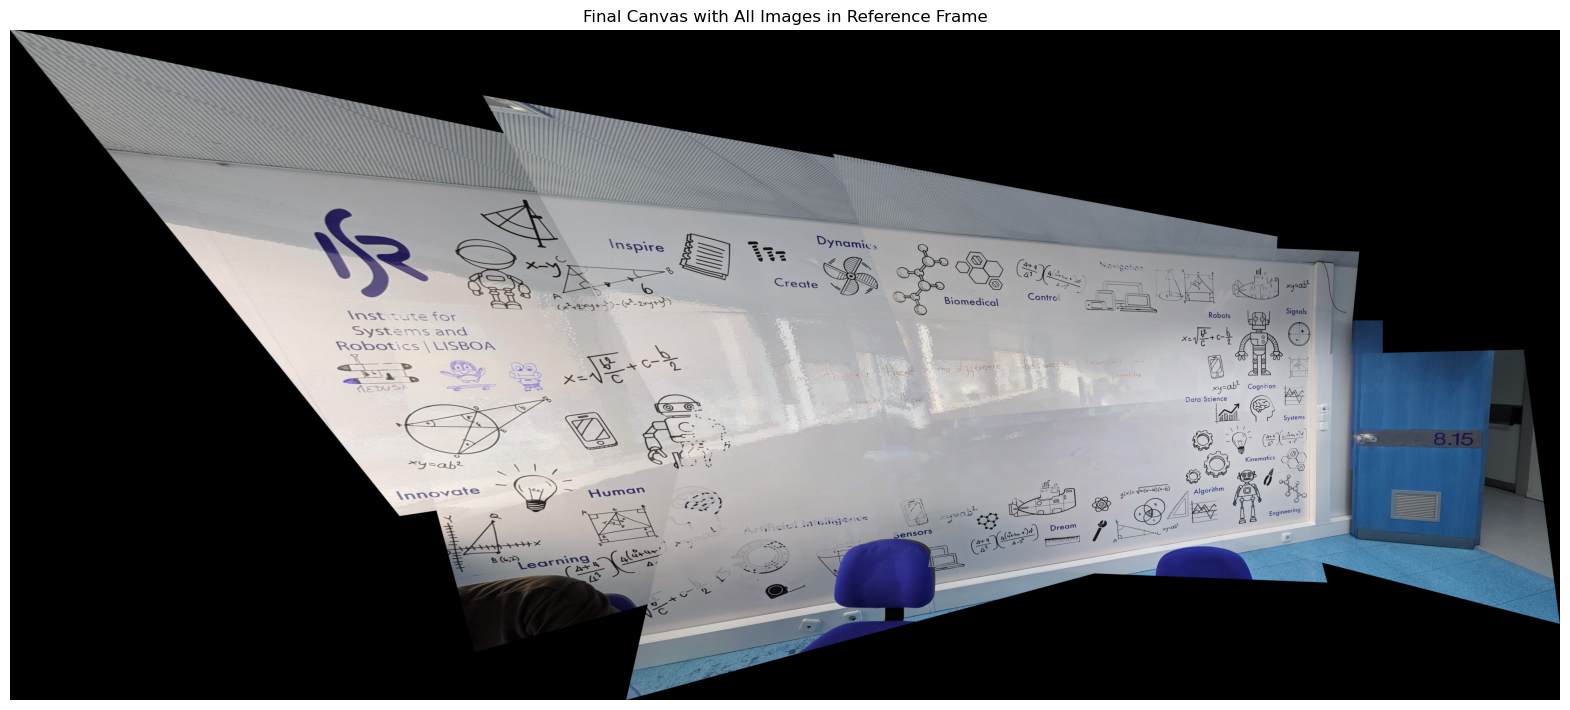

In [46]:
import cv2
import numpy as np

def create_canvas_with_images(ref_img, image_nodes):
    """
    Create a canvas with all images warped into the reference frame.
    
    Args:
        ref_img (np.ndarray): The reference image.
        image_nodes (list of ImageNode): List of ImageNode objects, each with an image, keypoints, descriptors, and homography.
    
    Returns:
        canvas (np.ndarray): The final canvas with all images aligned in the reference frame.
    """
    # Step 1: Determine the overall canvas size by transforming the corners of all images
    h_ref, w_ref = ref_img.shape[:2]
    
    # Get the corners of the reference image
    corners_ref = np.array([
        [0, 0],
        [w_ref, 0],
        [w_ref, h_ref],
        [0, h_ref]
    ], dtype=np.float32).reshape(-1, 1, 2)
    
    all_corners = [corners_ref]
    
    for node in image_nodes:
        if node.homography is not None:
            h_img, w_img = node.image.shape[:2]
            corners_img = np.array([
                [0, 0],
                [w_img, 0],
                [w_img, h_img],
                [0, h_img]
            ], dtype=np.float32).reshape(-1, 1, 2)
            
            # Warp the image corners to the reference frame
            warped_corners = cv2.perspectiveTransform(corners_img, node.homography)
            all_corners.append(warped_corners)
    
    # Combine all the corners to compute the overall canvas size
    all_corners = np.concatenate(all_corners, axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    # Compute the translation to shift everything into positive canvas space
    translation = [-xmin, -ymin]
    
    # Step 2: Create the translation matrix to shift all images
    translation_matrix = np.array([
        [1, 0, translation[0]],
        [0, 1, translation[1]],
        [0, 0, 1]
    ], dtype=np.float32)
    
    # Step 3: Warp the reference image into the new canvas
    canvas_size = (xmax - xmin, ymax - ymin)
    canvas = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8)  # Create an empty canvas
    
    # Warp the reference image
    ref_warped = cv2.warpPerspective(ref_img, translation_matrix, canvas_size)
    
    # Add the reference image to the canvas
    mask_ref = (ref_warped > 0).astype(np.uint8)  # Create a mask for the reference image
    canvas = cv2.add(canvas, ref_warped, mask=mask_ref.max(axis=2))
    
    # Step 4: Warp and blend all other images into the canvas
    for node in image_nodes:
        if node.homography is not None:
            # Combine the translation and the homography for the current image
            combined_homography = translation_matrix @ node.homography
            
            # Warp the image into the canvas
            warped_img = cv2.warpPerspective(node.image, combined_homography, canvas_size)
            
            # Create a mask for the current image
            mask_img = (warped_img > 0).astype(np.uint8)
            
            # Add the warped image to the canvas
            
            # Normalize the images for blending
            canvas_float = canvas.astype(np.float32) / 255.0
            warped_float = warped_img.astype(np.float32) / 255.0
            
            # Blend the images together using maximum intensity projection or simple overlay
            for c in range(3):  # Loop over each channel
                canvas_channel = canvas_float[:, :, c]
                warped_channel = warped_float[:, :, c]
                
                # Blend the two images using the max of both
                canvas_channel = np.maximum(canvas_channel, warped_channel)
                canvas[:, :, c] = (canvas_channel * 255).astype(np.uint8)
    
    return canvas

# Example usage:
final_canvas = create_canvas_with_images(ref_img, image_nodes)

# Display the final canvas
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(final_canvas, cv2.COLOR_BGR2RGB))
plt.title("Final Canvas with All Images in Reference Frame")
plt.axis('off')
plt.show()
